In [88]:
# from __future__ import division

from models import *
from utils.utils import *
from utils.datasets import *
from utils.kittiloader import *


import os
import sys
import time
import datetime
import argparse
import numpy as np

import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import NullLocator
import time

from mpl_toolkits.mplot3d import Axes3D

axes_limits = [
    [0, 10], # X axis range
    [-10, 10], # Y axis range
    [-3, 10]   # Z axis range
]
axes_str = ['X', 'Y', 'Z']


image_folder = 'examples/'
config_path = 'config/v390.cfg'
weights_path = 'weights/v390_final.weights'
kitti_path = '/home/zijieguo/project/KITTI/'
class_path = 'data/coco.names'
conf_thres = 0.8
nms_thres = 0.4
batch_size = 1
n_cpu = 16
img_size = 416
use_cuda = True
CUDA_available = torch.cuda.is_available() and use_cuda

detections = torch.tensor([
    [  5.0433, 208.0689, 133.5634, 274.0513,   0.9992,   0.9995,   2.0000],
         [202.3678, 203.0705, 242.1279, 233.4327,   0.9980,   0.9999,   2.0000],
         [118.8502, 203.6419, 208.2199, 263.8680,   0.9891,   0.9758,   2.0000]
#          ,[271.3281, 201.2100, 280.0563, 207.2144,   0.9638,   0.9832,   2.0000],
#          [314.0755, 218.4319, 416.3620, 269.0359,   0.9204,   0.9999,   2.0000],
#          [293.7480, 207.2141, 319.6446, 226.7405,   0.8638,   0.9870,   2.0000],
#          [248.1488, 202.3865, 267.4640, 215.2374,   0.8588,   0.9984,   2.0000]
])
if detections[0] is not None:
        detections_with_distance = torch.zeros((detections.shape[0],detections.shape[1]+1))
        detections_with_distance[:,:-1] = detections

In [93]:
for detection in detections_with_distance:
    img_id = 8
    img_path = 'examples/000008.png'
    detection = detection.numpy()
    img_size_after_resize = img_size
    lidar_path = '%straining/velodyne/%06d.bin' % (kitti_path, img_id)
    calib = calibread('%straining/calib/%06d.txt' % (kitti_path, img_id))
    img = cv2.imread('/home/zijieguo/project/PyTorch-YOLOv3/examples/%06d.png' % img_id, cv2.IMREAD_UNCHANGED)
    # img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    img_width_orig = img.shape[1]

    img_height_orig = img.shape[0]

    pad_x = max(img_height_orig - img_width_orig, 0) * (img_size_after_resize / max(img_width_orig, img_height_orig))
    pad_y = max(img_width_orig - img_height_orig, 0) * (img_size_after_resize / max(img_width_orig, img_height_orig))
    
    # Image height and width after padding is removed
    unpad_h = img_size_after_resize - pad_y
    unpad_w = img_size_after_resize - pad_x
    box_h = ((detection[3] - detection[1]) / unpad_h) * img_height_orig
    box_w = ((detection[2] - detection[0]) / unpad_w) * img_width_orig
    v_upper = ((detection[1] - pad_y // 2) / unpad_h) * img_height_orig
    u_left = ((detection[0] - pad_x // 2) / unpad_w) * img_width_orig
    v_bottom = v_upper + box_h
    u_right = u_left + box_w

    point_cloud = np.fromfile(lidar_path, dtype=np.float32).reshape(-1, 4)
    # detections with shape: (x1, y1, x2, y2, object_conf, class_score, class_pred)

    P2 = calib["P2"] # 3x4 matris projection matrix after rectification
    # （u,v,1） = dot(P2, (x,y,z,1))
    Height_of_camera = 1.65
    fu = P2[0][0]  # for horizontal position
    fv = P2[1][1]
    D_rough = Height_of_camera * fv / (v_bottom - img_height_orig/2)

    if D_rough > 0:
        # remove points that are located behind the camera:
        point_cloud = point_cloud[point_cloud[:, 0] > (D_rough - 3), :]
        # remove points that are located too far away from the camera:
        point_cloud = point_cloud[point_cloud[:, 0] < min(80, D_rough + 3), :]
        point_cloud = point_cloud[point_cloud[:,2] > -1.5,:]
        
        ########################################################################
        # point_cloud               n x 4   original xyzr value before cali in velo coordinate
        # point_cloud_xyz           n x 3   xyz value before cali in velo coordinate
        # point_cloud_xyz_hom       n x 4   xyz1 in velo coordinate
        # point_cloud_xyz_camera    n x 4   xyz1 in camera coordinate
        # point_cloud_camera        n x 4   xyzr in camera coordinate
        # img_points_hom            n x 3   uv_
        # img_points                n x 2   UV
        ########################################################################
        
        R0_rect = np.eye(4)
        R0_rect[0:3, 0:3] = calib["R0_rect"] # 3x3 -> 4x4 up left corner
        Tr_velo_to_cam = np.eye(4)
        Tr_velo_to_cam[0:3, :] = calib["Tr_velo_to_cam"] # 3x4 -> 4x4 up left corner

        # point_cloud_xyz = point_cloud[:, 0:3] # num_point x 3 (x,y,z,reflectance) reflectance don't need
        point_cloud_xyz_hom = np.ones((point_cloud.shape[0], 4))
        point_cloud_xyz_hom[:, 0:3] = point_cloud[:, 0:3] # (point_cloud_xyz_hom has shape (num_points, 4))
        # the 4th column are all 1

        # project the points onto the image plane (homogeneous coords):
        # (U,V,_) = P2 * R0_rect * Tr_velo_to_cam * point_cloud_xyz_hom
        # normalize: (U,V,1)
        img_points_hom = np.dot(P2, np.dot(R0_rect, np.dot(Tr_velo_to_cam, point_cloud_xyz_hom.T))).T # (point_cloud_xyz_hom.T has shape (4, num_points))
        img_points = np.zeros((img_points_hom.shape[0], 2))
        img_points[:, 0] = img_points_hom[:, 0]/img_points_hom[:, 2]
        img_points[:, 1] = img_points_hom[:, 1]/img_points_hom[:, 2]

        # transform the points into (rectified) camera coordinates:
        # normalize: (x,y,z,1)
#         point_cloud_xyz_camera_hom = np.dot(R0_rect, np.dot(Tr_velo_to_cam, point_cloud_xyz_hom.T)).T # (point_cloud_xyz_hom.T has shape (4, num_points))
#         point_cloud_xyz_camera = np.zeros((point_cloud_xyz_camera_hom.shape[0], 3))
#         point_cloud_xyz_camera[:, 0] = point_cloud_xyz_camera_hom[:, 0]/point_cloud_xyz_camera_hom[:, 3]
#         point_cloud_xyz_camera[:, 1] = point_cloud_xyz_camera_hom[:, 1]/point_cloud_xyz_camera_hom[:, 3]
#         point_cloud_xyz_camera[:, 2] = point_cloud_xyz_camera_hom[:, 2]/point_cloud_xyz_camera_hom[:, 3]

#         point_cloud_camera = point_cloud
#         point_cloud_camera[:, 0:3] = point_cloud_xyz_camera # reserve reflection

        row_mask = np.logical_and(
                        np.logical_and(img_points[:, 0] >= u_left,
                                       img_points[:, 0] <= u_right),
                        np.logical_and(img_points[:, 1] >= v_upper,
                                       img_points[:, 1] <= v_bottom))

        # filter out point are not in frustum area
#         frustum_point_cloud = point_cloud[row_mask, :]
#         frustum_point_cloud_xyz_camera = point_cloud_xyz_camera[row_mask, :]


In [94]:
point_cloud[row_mask,:]

array([[ 8.845,  0.805, -0.08 ,  0.   ],
       [ 8.775,  0.827, -0.078,  0.   ],
       [ 8.71 ,  0.834, -0.076,  0.   ],
       ...,
       [ 4.909,  1.638, -1.173,  0.   ],
       [ 4.896,  1.651, -1.171,  0.   ],
       [ 4.861,  1.647, -1.162,  0.   ]], dtype=float32)

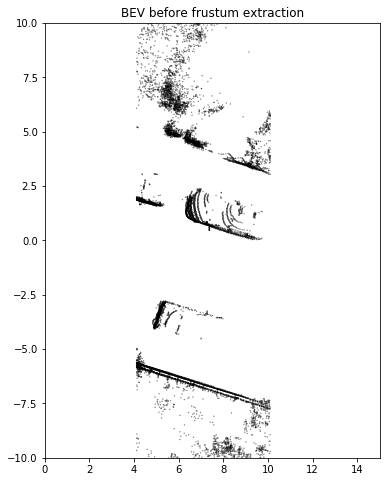

D_rough 7.112372944615878


In [95]:
f1 = plt.figure(figsize=(6, 8))
ax1 = f1.add_subplot(111)
ax1.scatter(point_cloud[:,0],point_cloud[:,1],
            s=0.05, c=[1]*len(point_cloud),
            facecolor='black', cmap='gray')
ax1.set_title('BEV before frustum extraction')
ax1.set_xlim(0,15)
ax1.set_ylim(-10,10)
plt.show()
print('D_rough',D_rough)

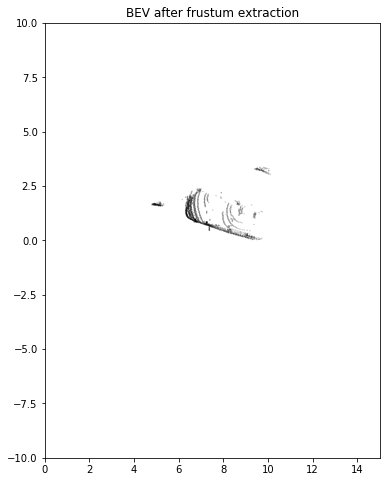

In [96]:
f2 = plt.figure(figsize=(6, 8))
ax2 = f2.add_subplot(111)
ax2.scatter(point_cloud[row_mask,0],point_cloud[row_mask,1],
            s=0.01, c=[1]*len(point_cloud[row_mask,:]),
            facecolor='black', cmap='gray')
ax2.set_title('BEV after frustum extraction')
ax2.set_xlim(0,15)
ax2.set_ylim(-10,10)
plt.savefig('BEV_after_frustum_extraction',format='pdf',dpi=300)

In [97]:
f2 = plt.figure(figsize=(10, 6))
ax2 = f2.add_subplot(111, projection='3d') 
ax.scatter(*np.transpose(velo_frame[:, axes]), s=0.01, c=velo_frame[:, 3], facecolor='black', cmap='gray')
# plt.savefig('BE')


[ 8.769 -7.15  -1.403  0.26 ]
[ 8.844 -7.165 -1.413  0.58 ]
[ 8.818 -7.098 -1.404  0.   ]
[ 8.425 -7.014 -1.403  0.63 ]
[ 8.522 -7.05  -1.417  0.65 ]
[ 8.581 -7.075 -1.426  0.66 ]
[ 8.667 -7.101 -1.439  0.66 ]
[ 8.757 -7.128 -1.451  0.7  ]
[ 8.888 -7.187 -1.471  0.66 ]
[ 7.879 -6.881 -1.405  0.43 ]
[ 7.941 -6.891 -1.413  0.43 ]
[ 8.027 -6.922 -1.426  0.41 ]
[ 8.107 -6.947 -1.438  0.49 ]
[ 8.171 -6.958 -1.447  0.45 ]
[ 8.236 -6.991 -1.457  0.46 ]
[ 8.321 -7.019 -1.47   0.45 ]
[ 8.396 -7.037 -1.481  0.45 ]
[ 8.479 -7.062 -1.493  0.44 ]
[ 7.076 -6.559 -1.407  0.51 ]
[ 7.141 -6.599 -1.419  0.38 ]
[ 7.195 -6.607 -1.426  0.5  ]
[ 7.279 -6.641 -1.439  0.37 ]
[ 7.332 -6.648 -1.446  0.48 ]
[ 7.41  -6.676 -1.459  0.36 ]
[ 7.473 -6.689 -1.467  0.47 ]
[ 7.547 -6.713 -1.479  0.38 ]
[ 7.593 -6.732 -1.486  0.48 ]
[ 9.439  0.113 -1.467  0.12 ]
[ 9.394  0.142 -1.459  0.27 ]
[ 9.269  0.155 -1.438  0.11 ]
[ 9.198  0.183 -1.426  0.16 ]
[ 9.124  0.21  -1.414  0.09 ]
[ 9.062  0.238 -1.404  0.08 ]
[ 9.071  0

In [135]:
from sklearn import linear_model

ransac = linear_model.RANSACRegressor()
ransac.fit(point_cloud[row_mask,1].reshape(-1,1),point_cloud[row_mask,0].reshape(-1,1))

RANSACRegressor(base_estimator=None, is_data_valid=None, is_model_valid=None,
        loss='absolute_loss', max_skips=inf, max_trials=100,
        min_samples=None, random_state=None, residual_threshold=None,
        stop_n_inliers=inf, stop_probability=0.99, stop_score=inf)

(-10, 10)

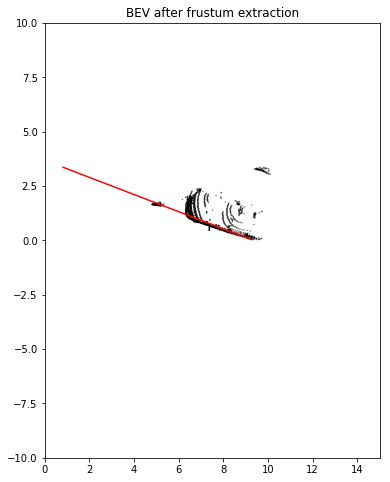

In [136]:
f3 = plt.figure(figsize=(6, 8))
ax3 = f3.add_subplot(111)
ax3.scatter(point_cloud[row_mask,0],point_cloud[row_mask,1],
            s=0.1, c=[1]*len(point_cloud[row_mask,:]),
            facecolor='black', cmap='gray',alpha = 0.8)
left_y = point_cloud[row_mask,1].min()
right_y = point_cloud[row_mask,1].max()
left_x = ransac.predict([[left_y,]])[0][0]
right_x = ransac.predict([[right_y,]])[0][0]

ax3.plot([left_x,right_x],[left_y,right_y],'k-', color = 'r')
ax3.set_title('BEV after frustum extraction')
ax3.set_xlim(0,15)
ax3.set_ylim(-10,10)

(-10, 10)

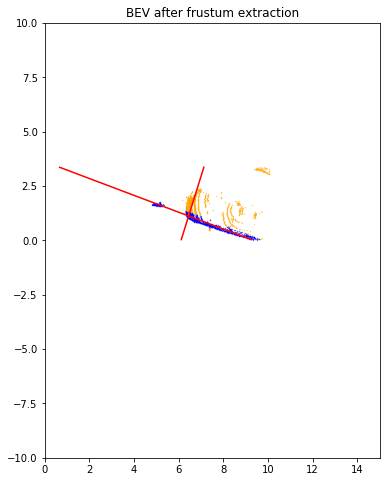

In [137]:
from itertools import compress
point_after_mask = point_cloud[row_mask,:]
left_y = point_after_mask[:,1].min()
right_y = point_after_mask[:,1].max()

ransac = linear_model.RANSACRegressor()
ransac.fit(point_after_mask[:,1].reshape(-1,1),point_after_mask[:,0].reshape(-1,1))
inlier_index =  list(compress(range(len(ransac.inlier_mask_)), ransac.inlier_mask_))

f3 = plt.figure(figsize=(6, 8))
ax3 = f3.add_subplot(111)
ax3.scatter(point_after_mask[inlier_index,0],point_after_mask[inlier_index,1],
            s=0.1, 
            facecolor='blue', alpha = 0.8)

left_y = point_cloud[row_mask,1].min()
right_y = point_cloud[row_mask,1].max()
left_x = ransac.predict([[left_y,]])[0][0]
right_x = ransac.predict([[right_y,]])[0][0]

ax3.plot([left_x,right_x],[left_y,right_y],'k-', color = 'r')

outlier_index =  list(compress(range(len(ransac.inlier_mask_)), [not i for i in ransac.inlier_mask_]))
ax3.scatter(point_after_mask[outlier_index,0],point_after_mask[outlier_index,1],
            s=0.1, 
            facecolor='orange', alpha = 0.8)

ransac.fit(point_after_mask[outlier_index,1].reshape(-1,1),point_after_mask[outlier_index,0].reshape(-1,1))
left_x = ransac.predict([[left_y,]])[0][0]
right_x = ransac.predict([[right_y,]])[0][0]
ax3.plot([left_x,right_x],[left_y,right_y],'k-', color = 'r')

ax3.set_title('BEV after frustum extraction')
ax3.set_xlim(0,15)
ax3.set_ylim(-10,10)